### Financial Inclusion in Africa

Financial inclusion remains one of the main obstacles to economic and human development in Africa. For example, across Kenya, Rwanda, Tanzania, and Uganda only 9.1 million adults (or 14% of adults) have access to or use a commercial bank account.

Traditionally, access to bank accounts has been regarded as an indicator of financial inclusion. Despite the proliferation of mobile money in Africa, and the growth of innovative fintech solutions, banks still play a pivotal role in facilitating access to financial services. Access to bank accounts enable households to save and make payments while also helping businesses build up their credit-worthiness and improve their access to loans, insurance, and related services. Therefore, access to bank accounts is an essential contributor to long-term economic growth.

The objective of this competition is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key factors driving individuals’ financial security.

In [1]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import plotly.express as px # type: ignore

In [2]:
#Loading Dataset
df = pd.read_csv(r"C:\Users\user\Desktop\financial-inclusion-in-africa\Train.csv")
test_df = pd.read_csv(r"C:\Users\user\Desktop\financial-inclusion-in-africa\Test.csv")#Loading Dataset
df = pd.read_csv(r"C:\Users\user\Desktop\financial-inclusion-in-africa\Train.csv")
test_df = pd.read_csv(r"C:\Users\user\Desktop\financial-inclusion-in-africa\Test.csv")

In [3]:
#Features extraction
df.drop(["year", "uniqueid"], axis=1, inplace=True)

In [4]:
#Spliting dataset into train and validation set
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.1, random_state=42)

In [5]:
#Speprating indepence and depence features
X_train = train.drop("bank_account", axis=1)
y_train = train.bank_account

#for validation

X_val = val.drop("bank_account", axis=1)
y_val = val.bank_account

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
enc = OneHotEncoder(sparse=False, handle_unknown="ignore")

In [7]:
y_val = le.fit_transform(y_val)
y_train = le.fit_transform(y_train)

In [8]:
def preprocess(df):
    num_col = df.select_dtypes(exclude="object").columns.to_list()
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df[num_col] = scaler.fit_transform(df[num_col])
    #Encoding order categorical features
    df["cellphone_access"] = le.fit_transform(df["cellphone_access"])
    df["gender_of_respondent"] = le.fit_transform(df["gender_of_respondent"])

    enc_col = df.select_dtypes(include="object").columns.to_list()
    enc.fit(df[enc_col])
    encoded_col = list(enc.get_feature_names_out(enc_col))
    df[encoded_col] = enc.transform(df[enc_col])
    df = df.drop(enc_col, axis=1)
    return df

In [9]:
#function for getting unique id from dataset
def Id(df):
    Id= df.uniqueid
    return Id

Id = Id(test_df)

In [10]:
#Extracting unwanted features
def extract(df1):
    df1.drop(["year", "uniqueid"], axis=1, inplace=True)
    return df1

In [11]:
X_val = preprocess(X_val)
X_train = preprocess(X_train)

In [12]:
test = extract(test_df)

In [13]:
test = preprocess(test)

### Training model

In [14]:
# machine learning
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [15]:
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
xg_y_model = xg_model.predict(X_val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_model))

Error rate of XGB classifier:  0.11644708882277943


c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


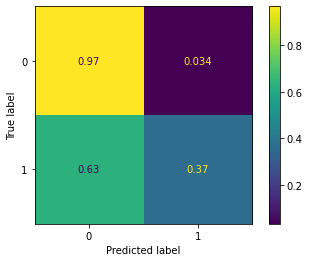

In [17]:
from sklearn.metrics import plot_confusion_matrix

# Get confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(xg_model,X_val, y_val,normalize='true')

In [18]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Optimize model parameters
# I run this code in google colab to make the execution much faster and use the best params in the next code
param_grid = {'min_child_weighth': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
my_xgb_model = GridSearchCV(xg_model, param_grid,n_jobs=-1,verbose=2,cv=5)
my_xgb_model.fit(X_train, y_train)
print(my_xgb_model.best_params_)       

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\user\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [06:52:38] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\learner.cc:742: 
Parameters: { "min_child_weighth" } are not used.

  warnings.warn(smsg, UserWarning)


{'gamma': 1, 'max_depth': 3, 'min_child_weighth': 1, 'subsample': 1.0}


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score

# fit by setting best parameters and Evaluate model
xgb_model = XGBClassifier(min_child_weight=1, gamma=1, subsample=0.8, max_depth=5)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)

# Get error rate
print("Error rate of the XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

Error rate of the XGB classifier:  0.10582235444113897


In [20]:
test_pred = xgb_model.predict(test)

In [21]:
submission = pd.DataFrame({"uniqueid": Id + " x " + test_df["country"],
                           "bank_account": test_pred})

In [23]:
submission

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0
...,...,...
10081,uniqueid_2998 x Uganda,0
10082,uniqueid_2999 x Uganda,0
10083,uniqueid_3000 x Uganda,0
10084,uniqueid_3001 x Uganda,0


In [30]:
submission.to_excel('firSbmission.xlsx', index = False)